In [1]:
from sys import path as sp
from pathlib import Path
from os import path

# Make scripts directory importable
sp.append(path.join((Path.cwd()).parent,"scripts"))

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from filepaths import paths
from visualisers import plot_history, plot_activity_v2, plot_full_v2
from dataloader import unlink_DStore, load_to_df, get_real_testdata, get_training_files

# Read Files & Set Column Names

In [3]:
# Self Training Data
trainfiles = get_training_files()
# testfiles = get_real_testdata()

train_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
train_classes = ['exit','reload','grenade','shield','idle']
# test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

targetfiles = trainfiles
cols = train_cols

targetfiles = unlink_DStore(targetfiles)

targetfiles

[PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_minjing_run2 (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_mingj_trainer2_noexit_reload.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_mingjun_reload.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_nds_ c.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_mingjun_exit_reload.txt')]

In [7]:
df = load_to_df(targetfiles, cols)

# Remove ';'
df[train_cols[6]] = df[train_cols[6]].str.slice(start=0, stop=-1)

# Cleanup anomalies
df = df[df['Activity_code'].isin(train_classes)]
df[cols[:6]] = df[cols[:6]].astype('int')
df = df[(df[cols[:6]] <= 255).all(axis=1)]
df = df[(df[cols[:6]] >= 0).all(axis=1)]
# df = df[filter]
df['time']=[i+1 for i in range(df.shape[0])]
# df['gz'] = df['gz'].astype('int')

df

,ax,ay,az,gx,gy,gz,Activity_code,time
1,71,129,131,125,124,129,idle,1
2,71,128,131,125,124,129,idle,2
3,70,127,130,125,125,129,idle,3
4,71,126,130,125,125,128,idle,4
5,71,126,130,125,125,127,idle,5
...,...,...,...,...,...,...,...,...
14934,116,78,157,144,201,197,idle,80695
14935,109,77,159,153,208,190,idle,80696
14936,107,83,157,141,205,173,idle,80697
14937,109,83,153,125,196,158,idle,80698


# Feature Extraction

In [8]:
df_copy = df.copy()
timestep = 40

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


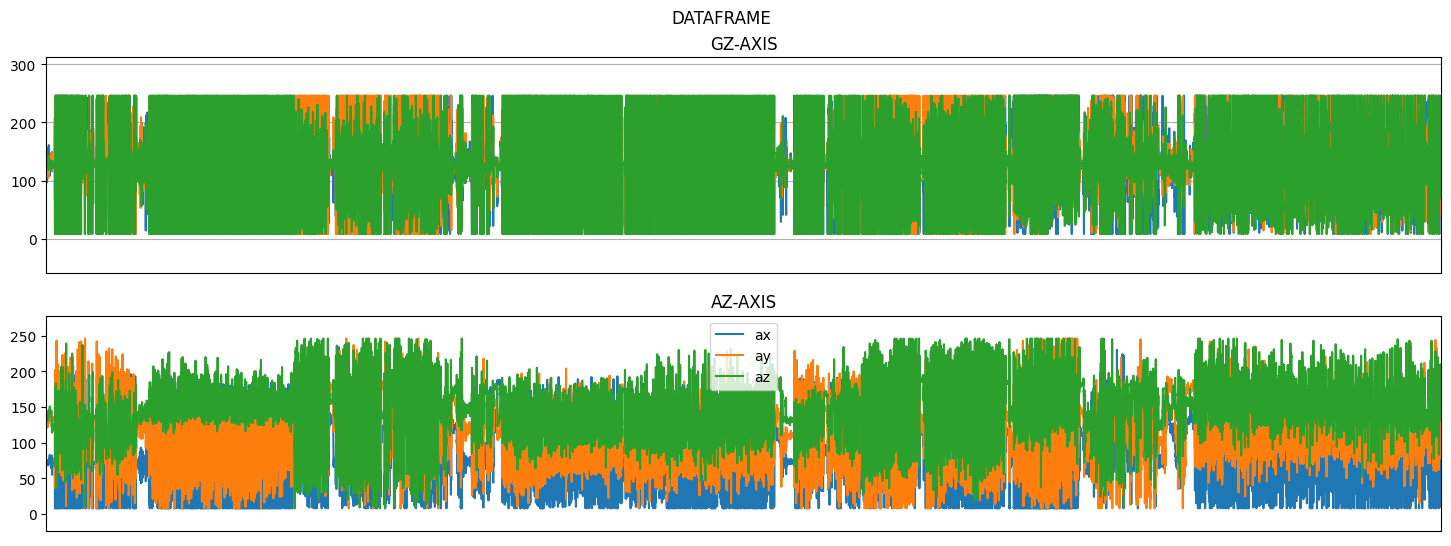

In [9]:
plot_full_v2(df_copy)

# Visualise Data

In [10]:
Fs=40
activities = df['Activity_code'].value_counts().index
print(activities)
df['Activity_code'].value_counts()

Index(['idle', 'reload', 'grenade', 'exit', 'shield'], dtype='object')


idle       44937
reload      9789
grenade     9241
exit        8460
shield      8272
Name: Activity_code, dtype: int64

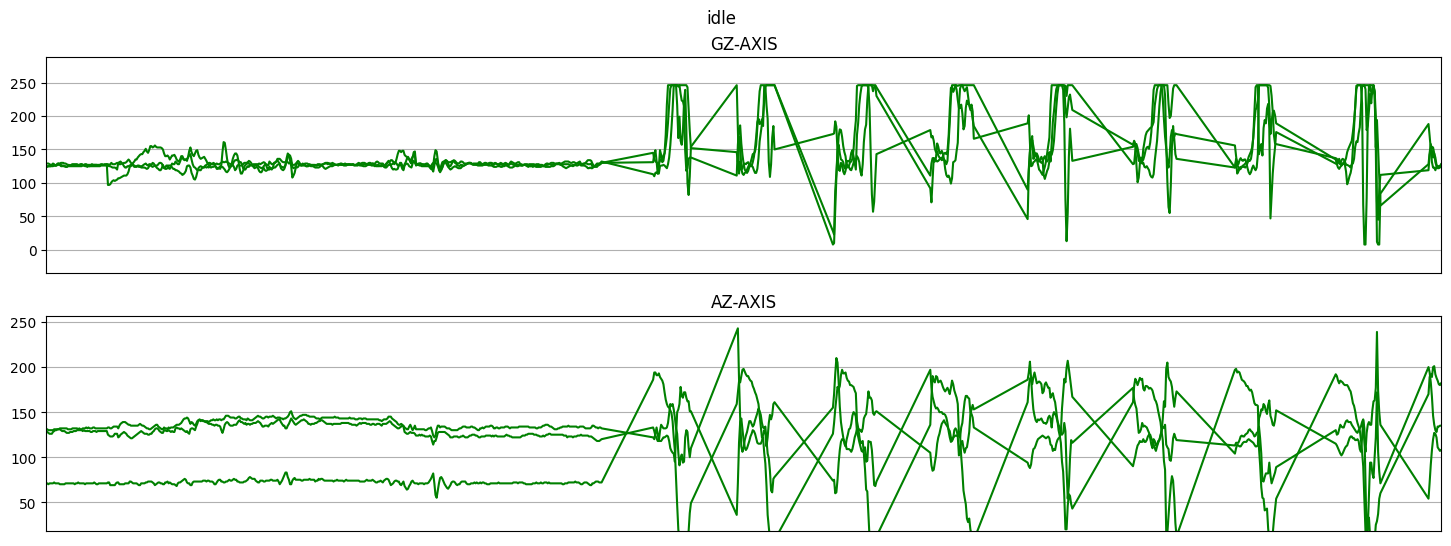

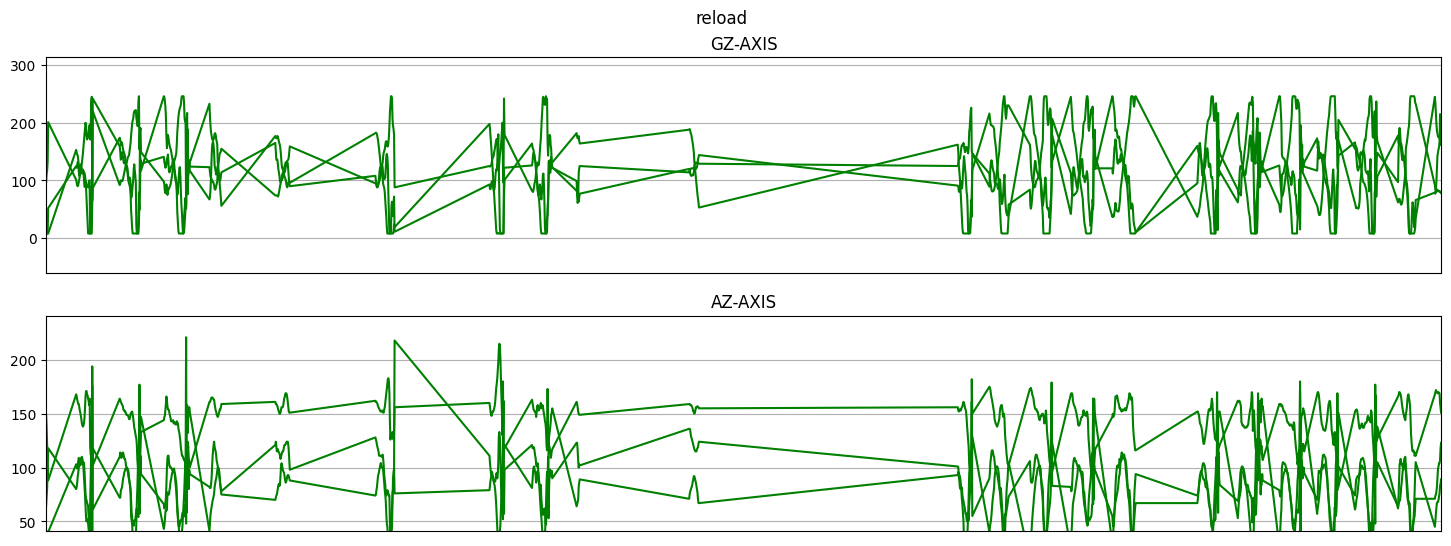

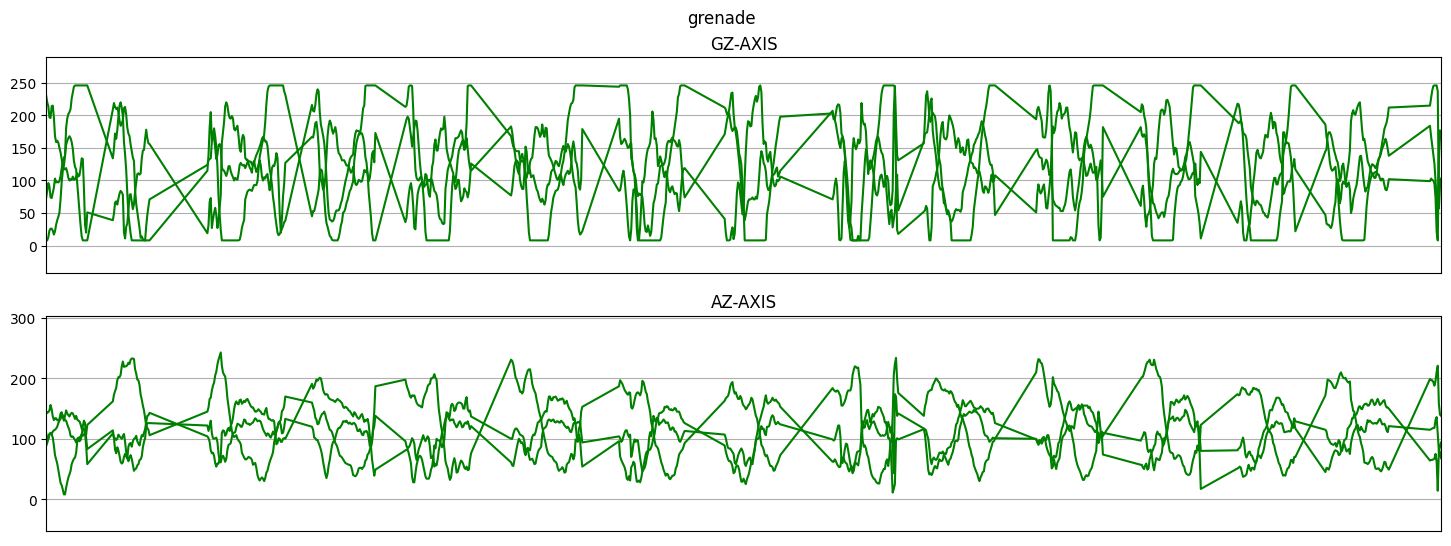

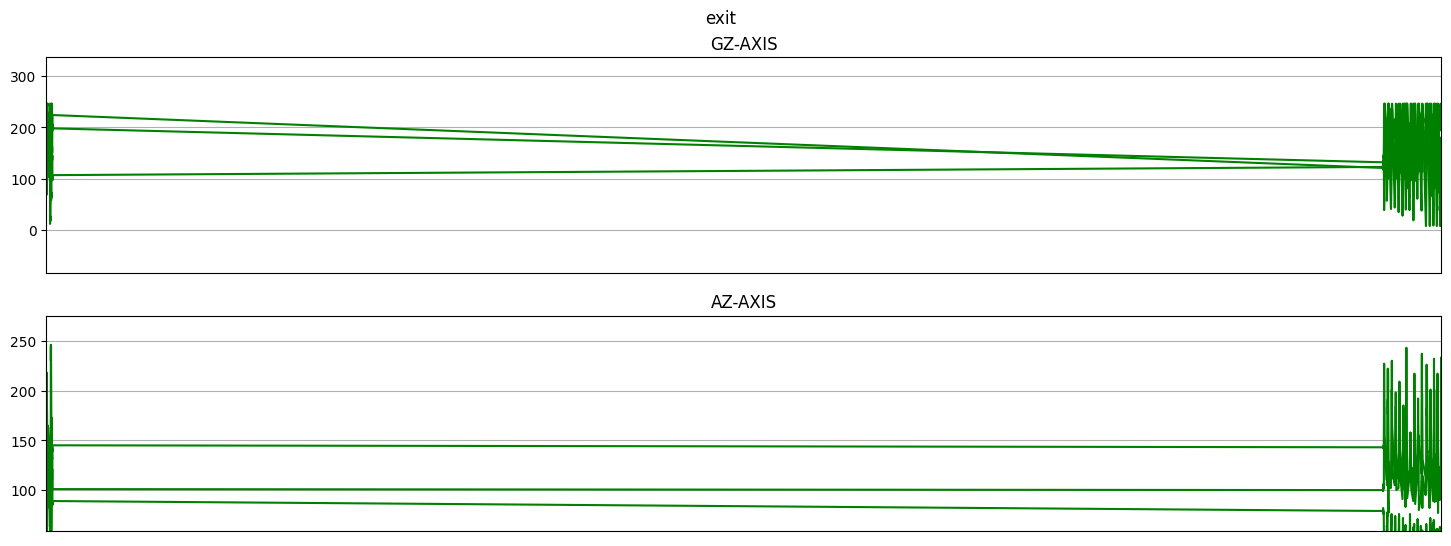

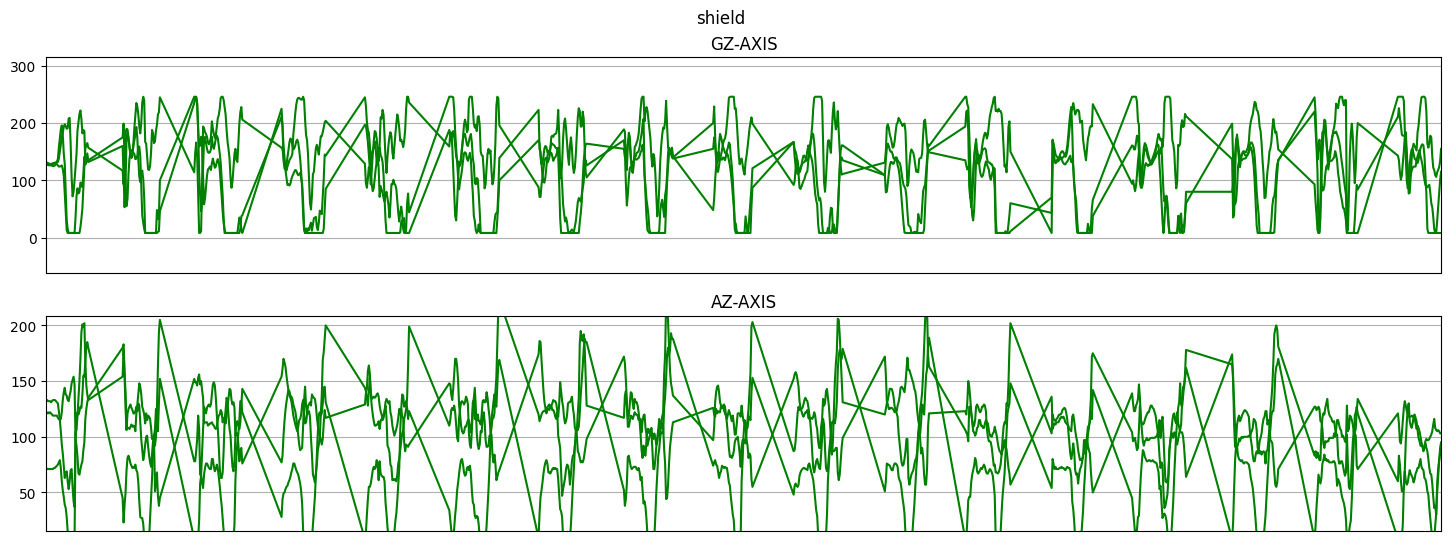

In [11]:
filt_df = df
for activity in activities:
    data_for_plot = filt_df[(filt_df['Activity_code'] == activity)][:Fs*20]
    plot_activity_v2(activity, data_for_plot)


In [12]:
# filt_df = filt_df.drop('Subject_id', axis=1)
filt_df = filt_df.drop('time', axis=1)

In [13]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from model_utils_training import encode, scale_255, scale_vals, scaled_data, get_frames,balance_frames

In [14]:
df_copy, label = encode(df_copy)

print(label.classes_)
df_copy.head()

['exit' 'grenade' 'idle' 'reload' 'shield']


,ax,ay,az,gx,gy,gz,Activity_code,time,label
1,71,129,131,125,124,129,idle,1,2
2,71,128,131,125,124,129,idle,2,2
3,70,127,130,125,125,129,idle,3,2
4,71,126,130,125,125,128,idle,4,2
5,71,126,130,125,125,127,idle,5,2


In [15]:
data = scale_vals(df_copy)
ds_X = data[['ax','ay','az','gx','gy','gz']]
ds_Y = data['label']
scaled_X = pd.DataFrame(data=ds_X, columns=['ax','ay','az','gx','gy','gz'])
scaled_X['Activity_code'] = ds_Y.values
scaled_X

,ax,ay,az,gx,gy,gz,Activity_code
1,0.278431,0.505882,0.513725,0.490196,0.486275,0.505882,2
2,0.278431,0.501961,0.513725,0.490196,0.486275,0.505882,2
3,0.274510,0.498039,0.509804,0.490196,0.490196,0.505882,2
4,0.278431,0.494118,0.509804,0.490196,0.490196,0.501961,2
5,0.278431,0.494118,0.509804,0.490196,0.490196,0.498039,2
...,...,...,...,...,...,...,...
14934,0.454902,0.305882,0.615686,0.564706,0.788235,0.772549,2
14935,0.427451,0.301961,0.623529,0.600000,0.815686,0.745098,2
14936,0.419608,0.325490,0.615686,0.552941,0.803922,0.678431,2
14937,0.427451,0.325490,0.600000,0.490196,0.768627,0.619608,2


In [16]:
import scipy.stats as stats

In [17]:
seconds = 1
Fs = 40
frame_size = int(Fs*seconds/2) # 40 Hz * 1/2 (every half second check) = 20
hop_size = int(Fs*seconds/2) # hop every 10 steps

In [18]:
x, y = get_frames(scaled_X, frame_size, hop_size, labelled=True)
x.shape, y.shape

/Users/anderson/Desktop/github/capstoneml/scripts/model_utils_training.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(filt_df['Activity_code'][i: i + frame_size])[0][0]


((4034, 20, 6), (4034,))

In [19]:
bal_raw = 8460
bal_now = int(bal_raw/hop_size)

# x, y = balance_frames(x, y, bal_now, classes_n=3)
x, y = balance_frames(x, y, bal_now)

x.shape, y.shape

0: 423 SAMPLES!!
1: 423 SAMPLES!!
2: 423 SAMPLES!!
3: 423 SAMPLES!!
4: 413 SAMPLES!!


((2105, 20, 6), (2105,))

In [57]:
BUFFER_SIZE=x.shape[0]
BATCH_SIZE=64

# Turn numpy arrays into tf dataset
ds = tf.data.Dataset.from_tensor_slices(x)
# Cache te dataset
ds = ds.cache()
ds = ds.shuffle(BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE)
# Reduce likelihood of bottlenecking
ds = ds.prefetch(int(BATCH_SIZE/2))

ds.as_numpy_iterator().next().shape

(64, 10, 6)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [21]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1684, 20, 6), (421, 20, 6), (1684,), (421,))

### MODEL BUILD

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam


In [31]:
model = Sequential()
model.add(Conv1D(16, 3, activation='relu', input_shape = X_train[0].shape))
model.add(Dropout(0.3))

model.add(Conv1D(32, 4, activation='relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

In [32]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 18, 16)            304       
                                                                 
 dropout_4 (Dropout)         (None, 18, 16)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 32)            2080      
                                                                 
 dropout_5 (Dropout)         (None, 15, 32)            0         
                                                                 
 flatten_1 (Flatten)         (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 24)                11544     
                                                                 
 dropout_6 (Dropout)         (None, 24)               

In [33]:
history = model.fit(X_train, Y_train, epochs=2000, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/2000
53/53 [==============================] - 0s 3ms/step - loss: 1.6202 - accuracy: 0.2031 - val_loss: 1.6026 - val_accuracy: 0.2993
Epoch 2/2000
53/53 [==============================] - 0s 1ms/step - loss: 1.6051 - accuracy: 0.2280 - val_loss: 1.5972 - val_accuracy: 0.3064
Epoch 3/2000
53/53 [==============================] - 0s 1ms/step - loss: 1.6026 - accuracy: 0.2251 - val_loss: 1.5860 - val_accuracy: 0.4394
Epoch 4/2000
53/53 [==============================] - 0s 1ms/step - loss: 1.5918 - accuracy: 0.2482 - val_loss: 1.5579 - val_accuracy: 0.4252
Epoch 5/2000
53/53 [==============================] - 0s 1ms/step - loss: 1.5601 - accuracy: 0.2844 - val_loss: 1.4881 - val_accuracy: 0.4727
Epoch 6/2000
53/53 [==============================] - 0s 1ms/step - loss: 1.5218 - accuracy: 0.2939 - val_loss: 1.4248 - val_accuracy: 0.4869
Epoch 7/2000
53/53 [==============================] - 0s 1ms/step - loss: 1.4924 - accuracy: 0.3314 - val_loss: 1.3672 - val_accuracy: 0.5368
Epoch 

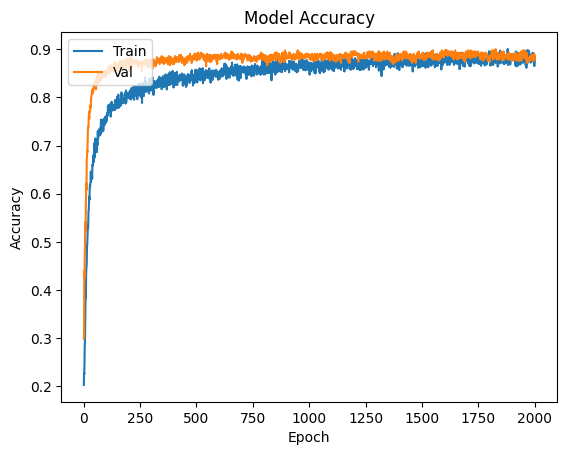

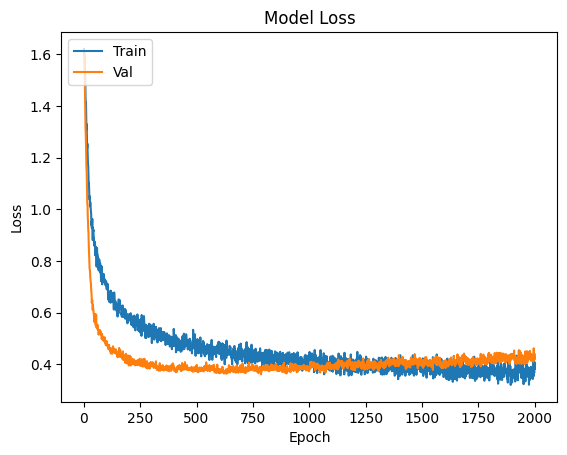

In [34]:
plot_history(history, 2000)

# Confusion Matrix

In [27]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [35]:
y_pred = model.predict(x)
classes_y = np.argmax(y_pred,axis=1)
chances = np.array([y_pred[i][np.argmax(y_pred[i])] for i in range(y_pred.shape[0])])

for i in range(chances.shape[0]):
    if chances[i] < 0.95:
        print(0, end=" ")
    else:
        print(classes_y[i], end=" ")

66/66 [==============================] - 0s 521us/step
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [29]:
print(classes_y)

[0 0 0 ... 4 4 4]


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

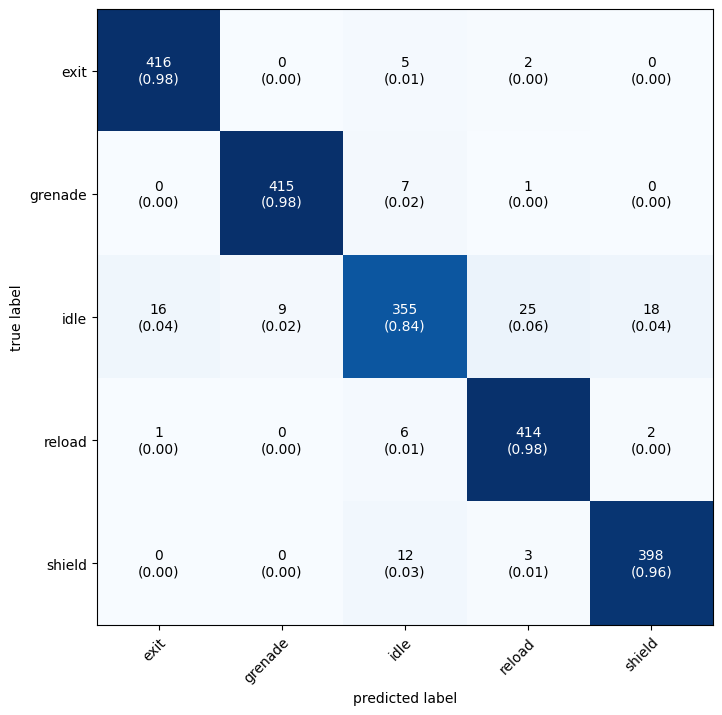

In [36]:
real_y = y
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


# Save Model

In [37]:
model_name = 'cnn_sunday_0'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model.save(MODEL_DIR)


# Load Model

In [16]:
model_name = 'model_cnn_real_0'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model = tf.keras.models.load_model(MODEL_DIR)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             152       
                                                                 
 dropout (Dropout)           (None, 18, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            528       
                                                                 
 dropout_1 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 24)                5784      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0

In [62]:
w_0 = model.layers[0].get_weights()[0]
b_0 = model.layers[0].get_weights()[1]
w_1 = model.layers[2].get_weights()[0]
b_1 = model.layers[2].get_weights()[1]
w_2 = model.layers[5].get_weights()[0]
b_2 = model.layers[5].get_weights()[1]
w_3 = model.layers[7].get_weights()[0]
b_3 = model.layers[7].get_weights()[1]

final_w = model.layers[9].get_weights()[0]
final_b = model.layers[9].get_weights()[1]


In [63]:
# layers = np.array([conv2d_w_0,conv2d_b_0,conv2d_w_1,conv2d_b_1,dense_w_0,dense_b_0,dense_w_1,dense_b_1])

layers = np.array([w_0,b_0,w_1,b_1,w_2,b_2,w_3,b_3, final_w, final_b])

for i in layers:
    print(i.shape)

(3, 6, 8)
(8,)
(4, 8, 16)
(16,)
(240, 24)
(24,)
(24, 12)
(12,)
(12, 4)
(4,)


/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_89833/4147205472.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  layers = np.array([w_0,b_0,w_1,b_1,w_2,b_2,w_3,b_3, final_w, final_b])


In [64]:
y_pred = model.predict(X_test[0:20])
classes_y = np.argmax(y_pred,axis=1)
classes_y

1/1 [==============================] - 0s 9ms/step


array([0, 0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 3])

In [65]:
Y_test[0:20]

array([0, 0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 3])

# Save Numpy

In [66]:
# outpath = paths.get('WEIGHT_DIR')
outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'conv_layers_real')
# SAVE NP
save_np = layers

np.save(outpath, save_np)

In [67]:
dataframe = np.array([X_train, X_test, Y_train, Y_test])

outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'conv_df_real')

np.save(outpath, dataframe)

/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_89833/2982726952.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataframe = np.array([X_train, X_test, Y_train, Y_test])


In [66]:
viz = layers[1]

print(viz)
print(viz.shape)

[ 0.9982494   0.6770703  -0.06876229  0.3487218  -0.01582066  0.
  0.         -0.00355527 -0.20330736 -0.31644577  0.         -0.08707343
  0.          0.         -0.32662997  0.         -0.07762001  0.
 -0.0094172   0.7266123  -0.30941087 -0.52208877 -0.01606345 -0.05250494]
(24,)


In [441]:
def ReLu(x):
    return np.maximum(0,x)

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def ori_kernel_mult(in_dps, kernels):
    # Num of filters (24)
    r = np.empty([in_dps.shape[0]-kernels.shape[0]+1, kernels.shape[2]])
    for j in range(0,kernels.shape[2]):
        # Num of output (shape[0]) > (18)
        out = np.zeros(in_dps.shape[0]-kernels.shape[0]+1)
        for i in range(0, in_dps.shape[0]-kernels.shape[0]+1):
            # Iterate kernel size sum > (3)
            sum = 0
            for k in range(0,kernels.shape[0]):
                # Iterate through prev filters / channels (6) 
                for f in range(0, kernels.shape[1]):
                    sum += kernels[k][f][j]*in_dps[i+k][f]
            r[i][j]=sum
    return r

def convolute(in_dps, kernels, k, stride,a):
    # print(stride, a)
    conv_p=0
    conv_kernels=np.zeros(kernels.shape[0]*kernels.shape[1]*kernels.shape[2])
    conv_kernels = conv_kernels.reshape(kernels.shape[0],kernels.shape[1],kernels.shape[2])
    in_int=in_dps[int(stride*kernels.shape[1]):int(stride*kernels.shape[1]+kernels.shape[1]*kernels.shape[0])]
    # print(in_int)
    for i in range(kernels.shape[1]):
        for j in range(kernels.shape[0]):
            conv_kernels[j][i][k]=kernels[j][i][k]
    for i in range(kernels.shape[1]):
        for j in range(kernels.shape[0]):
            idx = j*kernels.shape[1]+i
            # print(idx, i, j, k)
            conv_p += in_int[idx]*conv_kernels[j][i][k]
    out = conv_p
    return out

def kernel_mult(in_dps,kernels, biases, a):
    p = 1
    filters=kernels.shape[1]
    for i in in_dps.shape:
        p = p * i
    in_dps = in_dps.reshape(p)
    output=np.zeros((a-kernels.shape[0]+1)*kernels.shape[2])
    print(a-kernels.shape[0]+1)
    for i in range(kernels.shape[2]):
        for j in range(a-kernels.shape[0]+1):
            val = convolute(in_dps,kernels,i,j,a-kernels.shape[0]+1)
            output[j*kernels.shape[2]+i] = val + biases[i]
    return output


def kernel_add(in_dps, biases):
    for b in range(0,biases.shape[0]):
        for i in range(0,in_dps.shape[0]):
            in_dps[i][b] += biases[b]
    return in_dps

def self_add(in_dps, biases):
    for i in range(in_dps.shape[0]):
        in_dps[i]+=biases[i]
    return in_dps

In [459]:
# dense_test = X_test[0].reshape(120)
dense_test = X_test[1]
mult = kernel_mult(dense_test, layers[0], layers[1], 20)
# mult = ori_kernel_mult(dense_test, layers[0])
# mult = kernel_add(mult, layers[1])
mult = ReLu(mult)
mult = kernel_mult(mult, layers[2], layers[3], 18)
# mult = ori_kernel_mult(mult, layers[2])
# mult = kernel_add(mult, layers[3])
mult = ReLu(mult)
# mult = mult.reshape(720)
mult = np.dot(mult, layers[4])
mult = self_add(mult, layers[5])
mult = ReLu(mult)
mult = np.dot(mult, layers[6])
mult = self_add(mult, layers[7])
mult = ReLu(mult)
mult = np.dot(mult, layers[8])
mult = self_add(mult, layers[9])
mult = ReLu(mult)

# mult = softmax(mult)
print(mult.shape)
print(mult)

18
15
(4,)
[0.         0.91876486 0.         4.43290832]


In [38]:
intermediate_layers = model.layers[:10]
intermediate_model = Sequential(intermediate_layers)
intermediate_model.build(input_shape=(None,20,6,1))
intermediate_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             152       
                                                                 
 dropout (Dropout)           (None, 18, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            528       
                                                                 
 dropout_1 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 24)                5784      
                                                                 
 dropout_2 (Dropout)         (None, 24)               

In [39]:
yhat = intermediate_model.predict(X_test[0:25])

1/1 [==============================] - 0s 49ms/step


In [40]:
viz = yhat[0]
print(viz.shape)
print(viz)

(4,)
[9.9864537e-01 8.3152440e-07 4.1502778e-04 9.3872799e-04]


# Print Layers in Cpp

In [68]:
def printCpp(layer):
    wrap = layer.ndim
    if (wrap > 1):
        for i in range(len(layer)):
            print("{", end="")
            printCpp(layer[i])
            if i==len(layer)-1:
                print("}", end="")
            else:
                print("},", end=" \n")
    else:
        for i in range(len(layer)):
            if (i==(len(layer)-1)):
                print(layer[i],end="")
            else:
                print(layer[i],end=", ")


In [99]:
# i-=2
# toPrint = X_test[5:7].reshape(2,120)
# toPrint = Y_test[5:7]
toPrint = layers[8]

print("{", end="")
printCpp(toPrint)
print("};", end="\n")

{{-0.8757577, 0.05912632, 0.09932468, 0.21477053}, 
{0.0044303224, -0.038006492, -0.56587, -0.6866429}, 
{0.48046982, -0.52184236, 0.6048948, -0.6842622}, 
{0.07132181, -0.7183946, 0.11059915, -0.8024339}, 
{-0.5945972, 0.11449261, 0.31713483, -0.71885407}, 
{-0.17392, 0.2358421, -0.77541965, -1.0309747}, 
{-0.28213137, -1.8996767, -0.12002885, -0.26996583}, 
{-0.05378228, -0.95066804, 0.18506777, -0.7818162}, 
{-1.0283866, 0.28525448, -0.72799784, 0.3726984}, 
{0.53684545, 0.5932937, -0.2519535, -0.85684574}, 
{0.44448435, 0.5649827, -0.653739, -0.85743123}, 
{-0.36113086, -0.0109125655, -0.33740416, 0.88281304}};
